In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_excel(r"D:\Downloads\DSTC vòng 2\UPCOM_cleaned_last.xlsx")
df = df.drop("Unnamed: 0" , axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ticker           30200 non-null  object        
 1   timestamp        30200 non-null  datetime64[ns]
 2   open             30200 non-null  float64       
 3   high             30200 non-null  float64       
 4   low              30200 non-null  float64       
 5   close            30200 non-null  float64       
 6   volume           30200 non-null  int64         
 7   ema_50           30200 non-null  float64       
 8   ema_200          30200 non-null  float64       
 9   macd             30200 non-null  float64       
 10  macd_signal      30200 non-null  float64       
 11  macd_diff        30200 non-null  float64       
 12  rsi              30200 non-null  float64       
 13  bollinger_hband  30200 non-null  float64       
 14  bollinger_lband  30200 non-null  float

In [2]:
def create_labels(df, window=5, threshold=0.02):
    df['future_return'] = df.groupby('ticker')['close'].pct_change(periods=window).shift(-window)

    conditions = [
        (df['future_return'] > threshold),
        (df['future_return'] < -threshold)
    ]
    choices = [1, -1] 
    

    df['label'] = np.select(conditions, choices, default=0)
    
    df.dropna(subset=['future_return'], inplace=True)
    df.drop(columns=['future_return'], inplace=True)
    df['label'] = df['label'].astype(int)
    
    print("Tạo nhãn hoàn tất.")
    print("Phân phối nhãn:")
    print(df['label'].value_counts())
    
    return df

data = create_labels(df, window = 5, threshold=  0.02)

Tạo nhãn hoàn tất.
Phân phối nhãn:
label
 0    14074
 1     8409
-1     7467
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from torch.optim.lr_scheduler import ReduceLROnPlateau 

tickers = data["ticker"].unique()

VOL_WINDOWS = [10, 20]
LAG_INDICATOR_WINDOWS = [1, 3]

all_train_dfs = []
all_test_dfs = []

for ticker in tickers:
    ticker_df = data[data["ticker"] == ticker].copy()
    ticker_df.sort_values(by='timestamp', inplace=True)

    lags = [5, 10, 15]
    for lag in lags:
        ticker_df[f'return_lag_{lag}'] = ticker_df['return'].shift(lag)

    for window in VOL_WINDOWS:
        ticker_df[f'volatility_{window}'] = ticker_df['return'].rolling(window=window).std()

    ticker_df['rsi_momentum'] = ticker_df['rsi'] - ticker_df['rsi'].shift(1)
    ticker_df['macd_diff_momentum'] = ticker_df['macd_diff'] - ticker_df['macd_diff'].shift(1)
    ticker_df['price_vs_ema200'] = (ticker_df['close'] / ticker_df['ema_200']) - 1

    indicators_to_lag = ['rsi', 'mfi']
    for indicator in indicators_to_lag:
        for lag in LAG_INDICATOR_WINDOWS:
            ticker_df[f'{indicator}_lag_{lag}'] = ticker_df[indicator].shift(lag)

    ticker_df.dropna(inplace=True)
    ticker_df['label'] = ticker_df['label'].map({-1: 0, 0: 1, 1: 2})
    ticker_df.dropna(inplace=True)

    if ticker_df.empty:
        continue

    split_index = int(len(ticker_df) * 0.80)
    train_df_ticker = ticker_df.iloc[:split_index]
    test_df_ticker = ticker_df.iloc[split_index:]

    all_train_dfs.append(train_df_ticker)
    all_test_dfs.append(test_df_ticker)

train_df_combined = pd.concat(all_train_dfs)
test_df_combined = pd.concat(all_test_dfs)


X_train_combined = train_df_combined.drop(columns=['ticker', 'timestamp', 'label'])
y_train_combined = train_df_combined['label']

lgbm = lgb.LGBMClassifier(objective='multiclass', random_state=42)
lgbm.fit(X_train_combined, y_train_combined)

feature_importance_df = pd.DataFrame({
    'feature': X_train_combined.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

top_15_features = feature_importance_df['feature'].head(15).tolist()
print(top_15_features)


X_train_top_features = X_train_combined[top_15_features]
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(X_train_top_features)

def create_lstm_dataset_clf(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
all_X_train_lstm, all_y_train_lstm = [], []
all_X_test_lstm, all_y_test_lstm = [], []

for train_df_ticker, test_df_ticker in zip(all_train_dfs, all_test_dfs):
    X_train_ticker_top = train_df_ticker[top_15_features]
    y_train_ticker = train_df_ticker['label']
    X_test_ticker_top = test_df_ticker[top_15_features]
    y_test_ticker = test_df_ticker['label']

    X_train_scaled = feature_scaler.transform(X_train_ticker_top)
    X_test_scaled = feature_scaler.transform(X_test_ticker_top)

    y_train_np = y_train_ticker.values
    y_test_np = y_test_ticker.values

    X_train_w, y_train_w = create_lstm_dataset_clf(X_train_scaled, y_train_np, TIME_STEPS)
    X_test_w, y_test_w = create_lstm_dataset_clf(X_test_scaled, y_test_np, TIME_STEPS)

    if X_train_w.shape[0] > 0:
        all_X_train_lstm.append(X_train_w)
        all_y_train_lstm.append(y_train_w)
    if X_test_w.shape[0] > 0:
        all_X_test_lstm.append(X_test_w)
        all_y_test_lstm.append(y_test_w)

X_train_full = np.concatenate(all_X_train_lstm)
y_train_full = np.concatenate(all_y_train_lstm)
X_test_final = np.concatenate(all_X_test_lstm)
y_test_final = np.concatenate(all_y_test_lstm)



val_ratio = 0.10
n_val = int(len(X_train_full) * val_ratio)
n_train = len(X_train_full) - n_val

X_train_split, y_train_split = X_train_full[:n_train], y_train_full[:n_train]
X_val_split, y_val_split = X_train_full[n_train:], y_train_full[n_train:]

print(f"Kích thước tập train: X={X_train_split.shape}, y={y_train_split.shape}")
print(f"Kích thước tập validation: X={X_val_split.shape}, y={y_val_split.shape}")
print(f"Kích thước tập test: X={X_test_final.shape}, y={y_test_final.shape}")


X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final, dtype=torch.long) 

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle cho tập train
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7402
[LightGBM] [Info] Number of data points in the train set: 23200, number of used features: 32
[LightGBM] [Info] Start training from score -1.379935
[LightGBM] [Info] Start training from score -0.749170
[LightGBM] [Info] Start training from score -1.288636
['price_vs_ema200', 'volatility_20', 'volatility_10', 'volume', 'bollinger_bw', 'macd_signal', 'ema_200', 'macd_diff', 'bollinger_pct', 'rsi_lag_3', 'mfi_lag_3', 'macd', 'mfi', 'macd_diff_momentum', 'rsi']
Kích thước tập train: X=(20430, 10, 15), y=(20430,)
Kích thước tập validation: X=(2270, 10, 15), y=(2270,)
Kích thước tập test: X=(5300, 10, 15), y=(5300,)



Sử dụng thiết bị: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- BẮT ĐẦU HUẤN LUYỆN ---
Epoch  1/100 | Train Loss: 1.060491 | Val Loss: 1.061035
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  2/100 | Train Loss: 1.027959 | Val Loss: 1.063654
Epoch  3/100 | Train Loss: 1.016255 | Val Loss: 1.059289
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  4/100 | Train Loss: 1.010324 | Val Loss: 1.056967
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  5/100 | Train Loss: 1.007754 | Val Loss: 1.055233
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  6/100 | Train Loss: 1.006336 | Val Loss: 1.054561
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  7/100 | Train Loss: 1.005004 | Val Loss: 1.054338
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifier_improved.pth
Epoch  8/100 | Train Loss: 1.004145 | Val Loss: 1.053786
 -> Val loss cải thiện. Đã lưu model tại: best_lstm_classifi

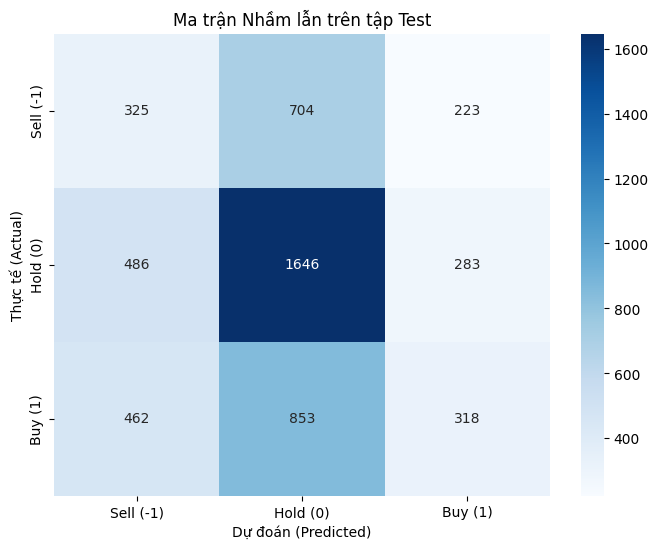

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nSử dụng thiết bị: {device}")


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, num_layers=2, num_classes=3, dropout=0.3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, num_classes)

    def forward(self, input_seq):
        h0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

input_size = X_train_split.shape[2]
num_classes = 3
model = LSTMClassifier(input_size=input_size, num_classes=num_classes, hidden_layer_size=128).to(device)



loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)


epochs = 100
early_stopping_patience = 15
epochs_no_improve = 0


train_losses, val_losses = [], []
best_val_loss = float('inf')
model_save_path = 'best_lstm_classifier_improved.pth'

print("Start")
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred_logits = model(seq)
        loss = loss_function(y_pred_logits, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for seq, labels in val_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred_logits = model(seq)
            loss = loss_function(y_pred_logits, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1:2}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}')

    scheduler.step(avg_val_loss)


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f' -> Val loss cải thiện. Đã lưu model tại: {model_save_path}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'\n--- Dừng sớm! Không có cải thiện Val loss trong {early_stopping_patience} epochs. ---')
            break

print("\n--- HUẤN LUYỆN HOÀN TẤT ---")


print(f"\n--- TẢI LẠI TRỌNG SỐ TỐT NHẤT TỪ {model_save_path} ---")
try:
    model.load_state_dict(torch.load(model_save_path))
except FileNotFoundError:
    print("Không tìm thấy file model đã lưu. Sử dụng model cuối cùng để đánh giá.")

model.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.to(device), labels.to(device)
        y_pred_logits = model(seq)
        y_pred = torch.argmax(y_pred_logits, dim=1)
        all_predictions.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



target_names = ['Sell (-1)', 'Hold (0)', 'Buy (1)']
print(classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0))


cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Ma trận Nhầm lẫn trên tập Test')
plt.show()

